In [1]:
!pip install gtfs-realtime-bindings geopandas contextily

In [1]:
from google.transit import gtfs_realtime_pb2
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
import zipfile

In [3]:
tvarb_tid = pd.read_csv('./data/2-working-data/selected-trips.csv', index_col=0)
tvarb_tid.trip_id = tvarb_tid.trip_id.astype(str)
tvarb_tid

route_id  service_id            trip_id  trip_headsign  \
0       9011001000100000           1  14010000574093920            NaN   
1       9011001000100000           2  14010000574097598            NaN   
2       9011001000100000           2  14010000574098087            NaN   
3       9011001000100000           1  14010000574101774            NaN   
4       9011001000100000           3  14010000574102788            NaN   
...                  ...         ...                ...            ...   
109875  9011008003600000         891  14010000597510267            NaN   
109876  9011008003600000        1138  14010000597510324            NaN   
109877  9011008003600000         702  14010000597510243            NaN   
109878  9011008003600000         679  14010000597510366            NaN   
109879  9011008003600000         679  14010000597510345            NaN   

        direction_id  shape_id          agency_id route_short_name  \
0                  1         1  14010000000001001                1   
1                  1         1  14010000000001001                1   
2                  1         1  14010000000001001                1   
3                  1         1  14010000000001001                1   
4                  1         1  14010000000001001                1   
...              ...       ...                ...              ...   
109875             0      3740  14010000000002071               36   
109876             0      3743  14010000000002071               36   
109877             0      3740  14010000000002071               36   
109878             0      3739  14010000000002071               36   
109879             0      3744  14010000000002071               36   

       route_long_name  route_type        route_desc  
0                  NaN         700           blåbuss  
1                  NaN         700           blåbuss  
2                  NaN         700           blåbuss  
3                  NaN         700           blåbuss  
4                  NaN         700           blåbuss  
...                ...         ...               ...  
109875             NaN        1000  Waxholmsbolagets  
109876             NaN        1000  Waxholmsbolagets  
109877             NaN        1000  Waxholmsbolagets  
109878             NaN        1000  Waxholmsbolagets  
109879             NaN        1000  Waxholmsbolagets  

[109880 rows x 11 columns]

In [4]:
filenames = glob("./data/1-koda-gtfs-rt-extracted/sl/VehiclePositions/2021/12/01/14/*.pb") # /*.pb

details = []

for file in tqdm(filenames): 
    response = open(file, 'rb')
    feed = gtfs_realtime_pb2.FeedMessage()
    feed.ParseFromString(response.read())
    
    details += [
        (e.id, feed.header.timestamp, e.vehicle.trip.trip_id, e.vehicle.vehicle.id, e.vehicle.timestamp, 
         Point(e.vehicle.position.longitude, e.vehicle.position.latitude))
        for e in feed.entity
    ]
    break;

  0%|          | 0/1620 [00:00<?, ?it/s]

In [5]:
gdf = gpd.GeoDataFrame(details, columns=['eid', 'timestamp', 'tid', 'vid', 'ts', 'geometry'])
gdf.set_crs(epsg=4326, inplace=True)
gdf

eid   timestamp                tid               vid  \
0    253867962691616769  1638363639  14010000593321867  9031001001004806   
1    253867965982507009  1638363639  14010000587454511  9031001001004825   
2    253867962053492737  1638363639  14010000593608099  9031001001007606   
3    253867962691944449  1638363639  14010000568290091  9031001003006883   
4    253867963332427777  1638363639  14010000589734366  9031001001507173   
..                  ...         ...                ...               ...   
967  253867959145858049  1638363639  14010000591935252  9031001001506964   
968  253867963331837953  1638363639  14010000575240069  9031001001506609   
969  253867962054868993  1638363639  14010000587452553  9031001001004063   
970  253867963328299009  1638363639  14010000532690861  9031001003007210   
971  253867965984800769  1638363639  14010000564195604  9031001003003528   

             ts                   geometry  
0    1638363639  POINT (18.05712 59.33096)  
1    1638363639  POINT (18.01260 59.33554)  
2    1638363638  POINT (18.00712 59.27828)  
3    1638363638  POINT (17.62846 59.19300)  
4    1638363639  POINT (18.06088 59.49448)  
..          ...                        ...  
967  1638363638  POINT (17.81171 59.29442)  
968  1638363639  POINT (17.96154 59.40895)  
969  1638363638  POINT (18.02928 59.33217)  
970  1638363639  POINT (17.53805 59.19902)  
971  1638363639  POINT (17.85814 59.41858)  

[972 rows x 6 columns]

In [6]:
gdf_merged = gdf.merge(tvarb_tid, how='left', left_on='tid', right_on='trip_id')
gdf_merged#[gdf_merged.route_desc.str.contains('Tvär') == True]
gdf_merged

eid   timestamp                tid               vid  \
0    253867962691616769  1638363639  14010000593321867  9031001001004806   
1    253867965982507009  1638363639  14010000587454511  9031001001004825   
2    253867962053492737  1638363639  14010000593608099  9031001001007606   
3    253867962691944449  1638363639  14010000568290091  9031001003006883   
4    253867963332427777  1638363639  14010000589734366  9031001001507173   
..                  ...         ...                ...               ...   
967  253867959145858049  1638363639  14010000591935252  9031001001506964   
968  253867963331837953  1638363639  14010000575240069  9031001001506609   
969  253867962054868993  1638363639  14010000587452553  9031001001004063   
970  253867963328299009  1638363639  14010000532690861  9031001003007210   
971  253867965984800769  1638363639  14010000564195604  9031001003003528   

             ts                   geometry          route_id  service_id  \
0    1638363639  POINT (18.05712 59.33096)  9011001006500000         1.0   
1    1638363639  POINT (18.01260 59.33554)  9011001005600000        29.0   
2    1638363638  POINT (18.00712 59.27828)  9011001014300000         1.0   
3    1638363638  POINT (17.62846 59.19300)  9011001075800000         1.0   
4    1638363639  POINT (18.06088 59.49448)  9011001061000000        16.0   
..          ...                        ...               ...         ...   
967  1638363638  POINT (17.81171 59.29442)  9011001017600000       794.0   
968  1638363639  POINT (17.96154 59.40895)  9011001052300000        16.0   
969  1638363638  POINT (18.02928 59.33217)  9011001000400000         1.0   
970  1638363639  POINT (17.53805 59.19902)  9011001078000000       139.0   
971  1638363639  POINT (17.85814 59.41858)  9011001055000000       139.0   

               trip_id  trip_headsign  direction_id  shape_id     agency_id  \
0    14010000593321867            NaN           0.0     954.0  1.401000e+16   
1    14010000587454511            NaN           1.0     934.0  1.401000e+16   
2    14010000593608099            NaN           0.0    1111.0  1.401000e+16   
3    14010000568290091            NaN           1.0    2853.0  1.401000e+16   
4    14010000589734366            NaN           0.0    2141.0  1.401000e+16   
..                 ...            ...           ...       ...           ...   
967  14010000591935252            NaN           0.0    1209.0  1.401000e+16   
968  14010000575240069            NaN           1.0    1764.0  1.401000e+16   
969  14010000587452553            NaN           1.0      20.0  1.401000e+16   
970  14010000532690861            NaN           1.0    2878.0  1.401000e+16   
971  14010000564195604            NaN           0.0    1891.0  1.401000e+16   

    route_short_name route_long_name  route_type route_desc  
0                 65             NaN       700.0        NaN  
1                 56             NaN       700.0        NaN  
2                143             NaN       700.0        NaN  
3                758             NaN       700.0        NaN  
4                610             NaN       700.0        NaN  
..               ...             ...         ...        ...  
967              176             NaN       700.0    blåbuss  
968              523             NaN       700.0        NaN  
969                4             NaN       700.0    blåbuss  
970              780             NaN       700.0        NaN  
971              550             NaN       700.0        NaN  

[972 rows x 17 columns]

<ipython-input-12-ec6cff611a4f>:4: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf[gdf.distance(poit) < 0.05].plot(ax=ax)


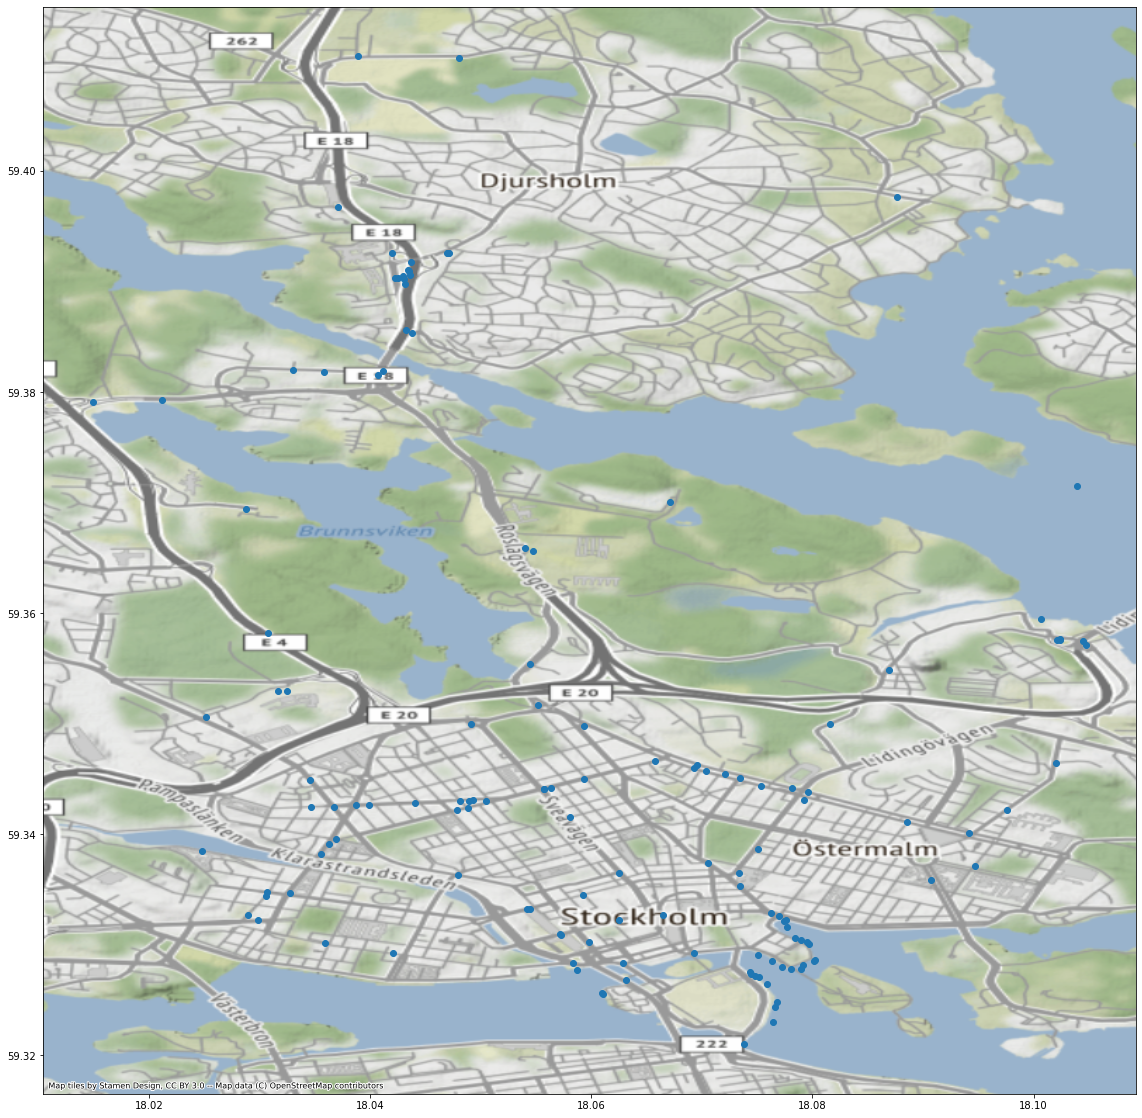

In [12]:
poit = Point( 18.062403913947964, 59.36964634265868)

fig, ax = plt.subplots(figsize=(20,20))
gdf[gdf.distance(poit) < 0.05].plot(ax=ax)
cx.add_basemap(ax, crs=gdf.crs)